In [1]:
import pandas_datareader.data as web
df = web.DataReader('USDCAD=X', 'yahoo', start='2007-07-22', end='2012-03-28')

<AxesSubplot:xlabel='Date'>

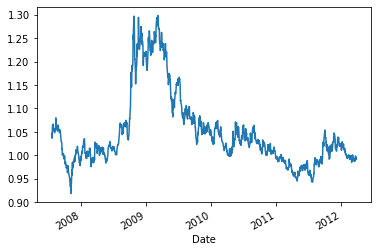

In [4]:
data = df['Adj Close']
data.plot()

In [22]:
#### 귀무가설 기각할 수 없음 - Stationary하다
from statsmodels.tsa.stattools import adfuller
adfuller(data, maxlag=1, regression='c')


(-1.814955679296744,
 0.37306229931987056,
 0,
 1215,
 {'1%': -3.435743555099632,
  '5%': -2.8639217381867486,
  '10%': -2.568038075665972},
 -8111.811359194424)

In [18]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    ts = np.asarray(ts)
    
    nobs = ts.shape[0]
    maxlag = 1
    tsdiff = np.diff(ts)
    
    tsdall = lagmat(tsdiff[:, None], maxlag, trim = 'both', original = 'in')
    nobs = tsdall.shape[0]
    tsdall[:, 0] = ts[-nobs - 1:-1]
    tsdshort = tsdiff[-nobs:]
    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return (adfstat, pvalue)

In [19]:
adf(data)

(-1.8319637867741008, 0.3647119589771163)

In [63]:
def get_hurst_exponent(ts, max_lag = 20):
    
    lags = range(2, max_lag)
    tau = []
    for lag in lags:
        diff = np.subtract(np.array(ts[lag:]), np.array(ts[:-lag]))
        tau.append(np.std(diff))
        
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    
    return reg[0]

In [64]:
get_hurst_exponent(data)

0.4665241917919693

In [65]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # Helper variables used during calculations
    lagvec = []
    tau = []
    # Create the range of lag values
    lags = range(2, 100)

    #  Step through the different lags
    for lag in lags:
        #  produce value difference with lag
        pdiff = np.subtract(ts[lag:],ts[:-lag])
        #  Write the different lags into a vector
        lagvec.append(lag)
        #  Calculate the variance of the difference vector
        tau.append(np.std(pdiff))

    #  linear fit to double-log graph
    m = np.polyfit(np.log10(np.asarray(lagvec)),
                   np.log10(np.asarray(tau).clip(min=0.0000000001)),
                   1)
    # return the calculated hurst exponent
    return m[0]

In [ ]:
def variance_ratio_test(ts, lag = 2):
    ts = np.asarray(ts)
    diff1 = np.substract(ts[1:], ts[:-1])
    difftau = 

In [67]:
#### ??? 왜 이렇게 되는거지???
def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Apply the formula to calculate the test
    n = len(ts)
    mu  = sum(ts[1:n]-ts[:n-1])/n;
    m=(n-lag+1)*(1-lag/n);
    b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
    t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
    return t/(lag*b);

In [68]:
variance_ratio(data)

1.0078634031661593

In [97]:
#### example 2.4 설명대로 수행(regression 활용)
def half_life(ts):
    ts = np.asarray(ts)
    delta_ts = np.diff(ts)
    lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
    lamda_sol = np.linalg.lstsq(lag_ts, delta_ts)
    print('lamda:', lamda_sol[0][0])
    return (np.log(2) / lamda_sol[0])[0]   #### (-) 붙여야되는거 아닌가?

### lamda가 양수이므로 price series is not at all mean reverting(??)

In [98]:
half_life(data)

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


116.06915736009762

In [144]:
def lag_fun(ts, lag_num):
    return np.hstack([np.zeros(lag_num), np.asarray(data)[:-lag_num]]).T

In [145]:
def backtest_linear_mean_reverting(ts):
    lookback = round(half_life(ts))
    mktVal = -(ts - ts.rolling(lookback).mean()) / (ts.rolling(lookback).std())
    lag_mktVal = pd.Series(lag_fun(mktVal, 1))
    lag_ts = pd.Series(lag_fun(ts, 1))
    pnl = lag_mktVal * (ts.reset_index()['Adj Close'] - lag_ts) / lag_ts
    return pnl

In [146]:
backtest_linear_mean_reverting(data)

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0           NaN
1      -0.01016
2       0.00520
3       0.01180
4       0.01030
         ...   
1211    0.00090
1212    0.00680
1213   -0.00230
1214   -0.00510
1215    0.00420
Length: 1216, dtype: float64

lamda: 0.005971846408856899


/Users/qook/Coding/Finance_ML/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


<AxesSubplot:>

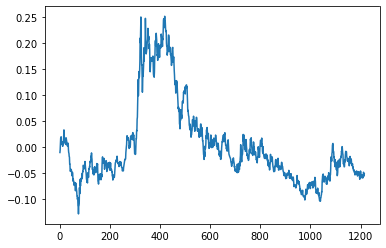

In [147]:
backtest_linear_mean_reverting(data).cumsum().plot()

In [151]:
df_ewa = web.DataReader('EWA', 'yahoo', start='2006-04-21', end='2012-04-09')
df_ewc = web.DataReader('EWC', 'yahoo', start='2006-04-21', end='2012-04-09')

In [168]:
df_ewa_data = df_ewa['Adj Close']
df_ewc_data = df_ewc['Adj Close']
df_ewa_ewc = pd.concat([df_ewa_data, df_ewc_data], axis = 1)
df_ewa_ewc.columns = ['ewa', 'ewc']

In [169]:
df_ewa_ewc

,ewa,ewc
Date,,
2006-04-20,10.209893,17.952795
2006-04-21,10.349227,18.179028
2006-04-24,10.330009,18.069559
2006-04-25,10.334815,18.098751
2006-04-26,10.541414,18.149839
...,...,...
2012-04-02,14.910575,23.200998
2012-04-03,14.677102,22.854601
2012-04-04,14.500422,22.451803


<AxesSubplot:xlabel='Date'>

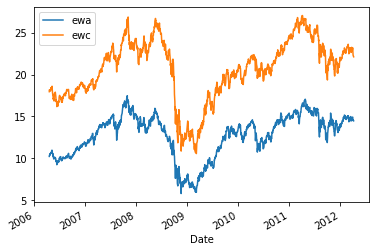

In [170]:
df_ewa_ewc.plot()

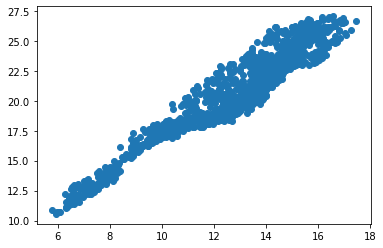

In [172]:
import matplotlib.pyplot as plt
plt.scatter(df_ewa_ewc['ewa'], df_ewa_ewc['ewc'])